# Copied from "fast_and_slow_rotators_analysis_011023.ipynb"
# 1/13/23 - Looking at oblate and prolate with delta_pa and uncertainties, first with obvious rotators and then experimenting with Anowar's procedure using probabilities.
# 1/23/23 - Looking at the new measurements from the b-spline models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({"figure.figsize" : (8, 6)})
from astropy.io import fits
import pandas as pd

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
#################################################
# objects
obj_names = ['SDSSJ0029-0055',
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

# Bring in SLACS data from table.

In [2]:
slacs_data = np.genfromtxt(f'{data_dir}slacs_tableA1.txt', delimiter='', dtype='U10')
slacs_qs = slacs_data[:,9].astype(float)
slacs_reffs = slacs_data[:,7].astype(float)
slacs_pa_phots = slacs_data[:,10].astype(float)
slacs_morphologies = slacs_data[:,15].astype(str)
slacs_sigmas = slacs_data[:,11].astype(float)
slacs_sigmas_err = slacs_data[:,12].astype(float)

ellipticities = np.empty(len(obj_names))
reffs = np.empty(len(obj_names))
slacs_PA_phots = np.empty(len(obj_names))
morphologies = np.empty(len(obj_names), dtype=str)
sdss_sigmas = np.empty(len(obj_names))
sdss_sigmas_err = np.empty(len(obj_names))

for i in range(len(obj_names)):
    name = obj_names[i]
    name = name[4:]
    if name == 'J1306+0600':
        ellipticities[i] = 1 - 0.909 # These values from Shajib 2020
        reffs[i] = 2.30
        slacs_PA_phot = 0
        morphologies[i] = ''
        sdss_sigmas[i] = 0
        sdss_sigmas_err[i] = 0
    else:
        q = slacs_qs[slacs_data[:,0]==name]
        ellipticities[i] = 1 - q[0]
        reffs[i] = slacs_reffs[slacs_data[:,0]==name]
        slacs_PA_phots[i] = slacs_pa_phots[slacs_data[:,0]==name]
        morphologies[i] = slacs_morphologies[slacs_data[:,0]==name][0]
        sdss_sigmas[i] = slacs_sigmas[slacs_data[:,0]==name]
        sdss_sigmas_err[i] = slacs_sigmas_err[slacs_data[:,0]==name]

In [3]:
def calc_V_sigma_squared (delta, omega, alpha):
    
    numerator = (1-delta) * omega - 1
    denominator = alpha * (1-delta) * omega + 1
    
    V_sigma_sq = numerator/denominator
    
    return V_sigma_sq

def calc_omega (e):
    
    numerator = np.arcsin(e)/np.sqrt(1-e**2) - e
    denominator = e - np.arcsin(e) * np.sqrt(1-e**2)
    
    omega = 0.5 * numerator/denominator
    
    return omega

def calc_e (epsilon):
    
    e = np.sqrt( 1 - (1 - epsilon)**2 )
    
    return e

def calc_isotropic_V_sigma (epsilon):
    
    # isotropic delta = 0
    delta = 0
    # alpha empirically = 0.15
    alpha = 0.15
    
    # calculations
    e = calc_e(epsilon)
    omega = calc_omega(e)
    V_sigma_squared = calc_V_sigma_squared(delta, omega, alpha)
    V_sigma_iso = np.sqrt(V_sigma_squared)
    
    return(V_sigma_iso)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


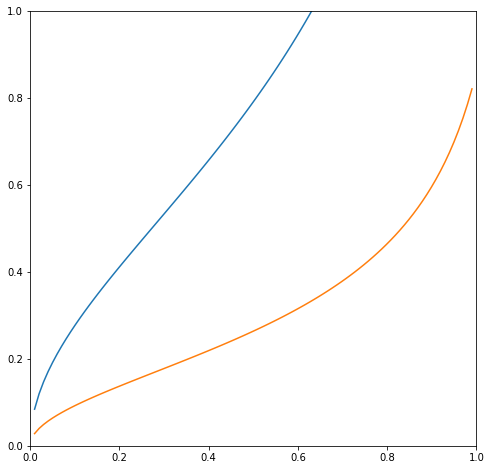

In [4]:
epsilons = np.linspace(0,1,100)
V_sigmas = np.zeros(100)

i=0
for epsilon in epsilons:
    V_sigma = calc_isotropic_V_sigma(epsilon)
    V_sigmas[i] = V_sigma
    i = i+1

plt.figure(figsize=(8,8))
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.plot(epsilons, V_sigmas)
plt.plot(epsilons, 1/3 * V_sigmas)

In [5]:
# Define function to calculate luminosity weights for rebinning from Voronoi bins to shells
### In this case, the shell will justbe the effective radius (shells = [1])

def calc_luminosity_weights_in_shells (bin_arrays, num_bins, bin_luminosities, pixel_luminosities, shells, reff):
    
    # create array with each bin and len num_bins
    luminosity_weights = np.zeros((num_bins, len(shells)))
    
    for i in range(num_bins):
        # pixels in this bin, take x and y coordinates
        in_bin = bin_arrays[:,2]==i
        bin_pixels = bin_arrays[in_bin]
        bin_xx = bin_pixels[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
        bin_yy = bin_pixels[:,1] - 21
        # luminosity of bin and of pixels in bin
        bin_luminosity = bin_luminosities[i]
        bin_pixels_lum = pixel_luminosities[in_bin]
        #print(bin_luminosity, np.sum(bin_pixels_lum))
        # calculate radius of each pixel in the bin
        bin_R = np.zeros(len(bin_pixels))
        for j in range(len(bin_pixels)):
            bin_R[j] = np.sqrt(bin_xx[j]**2 + bin_yy[j]**2)*0.1457 # arcsec
        # calculate fraction of these pixels in each shell
        for k in range(len(shells)):
            inner_shell = shells[k]
            if k == len(shells) - 1:
                outer_shell = 10 # everything extending to the farthest pixel
            else:
                outer_shell = shells[k+1]
            in_shell = (bin_R >= inner_shell*reff) & (bin_R <= outer_shell*reff)
            # weight pixels by fractional luminosity of total bin
            bin_luminosity_in_shell = np.sum(bin_pixels_lum[in_shell])#/bin_luminosity
            luminosity_weights[i,k] = bin_luminosity_in_shell
        
    return luminosity_weights

In [6]:
def lum_weight_bin (V, VD, dVD, lum):
    
    bin_weighted_V_sq = lum * V**2
    bin_weighted_VD_sq = lum * VD**2
    bin_weighted_dVD_sq = lum * 2 * VD * dVD

    return bin_weighted_V_sq, bin_weighted_VD_sq, bin_weighted_dVD_sq

def lum_weight_V_sigma (V_array, VD_array, dVD_array, lum_array):
    
    assert (len(V_array)==len(VD_array)) & (len(V_array)==len(lum_array)) & (len(V_array)==len(dVD_array))
    
    V_sq = 0
    VD_sq = 0
    dVD_sq = 0
    
    for i in range(len(V_array)):
        bin_V_sq, bin_VD_sq, bin_dVD_sq = lum_weight_bin(V_array[i], VD_array[i], dVD_array[i], lum_array[i])
        V_sq += bin_V_sq
        VD_sq += bin_VD_sq
        dVD_sq += bin_dVD_sq
    
    V_sigma_sq = V_sq/VD_sq
    V_sigma = np.sqrt(V_sigma_sq)
    
    VD_integrated_rms = np.sqrt(VD_sq/np.sum(lum_array))

    dVD_int_rms = dVD_sq / (2 * np.sqrt(np.sum(lum_array) * VD_sq))
    
    return(V_sigma, VD_integrated_rms, dVD_int_rms) # this is integrated out to the edge of my data right now
        

In [7]:
# Now let's do the lambda_R calculation


def calc_lambda_R (V_array, VD_array, R_array, lum_array):
    
    assert (len(V_array)==len(VD_array)) & (len(V_array)==len(lum_array)) & (len(V_array)==len(R_array))
    
    numerator = 0
    denominator = 0
    
    for i in range(len(V_array)):
        V = V_array[i]
        VD = VD_array[i]
        lum = lum_array[i]
        R = R_array[i]
        
        
        num = lum * R * np.abs(V)
        den = lum * R * np.sqrt(V**2 + VD**2)
        
        numerator += num
        denominator += den
        
    lambda_R = numerator / denominator
    
    return lambda_R


In [8]:
def calc_Vsig_to_lamR (V_sigma):
    k = 1.1
    numerator = k * V_sigma
    denominator = np.sqrt(1 + k**2 * V_sigma**2)
    lamR = numerator/denominator
    return lamR

In [9]:
def calc_R (bin_arrays, num_bins):
    
    bin_R_means = np.zeros(num_bins)
    
    for i in range(num_bins):
        bin_pixels = bin_arrays[bin_arrays[:,2]==i]
        bin_xx = bin_pixels[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
        bin_yy = bin_pixels[:,1] - 21
        bin_R = np.zeros(len(bin_pixels))
        for j in range(len(bin_pixels)):
            bin_R[j] = np.sqrt(bin_xx[j]**2 + bin_yy[j]**2)
        bin_R_means[i] = np.mean(bin_R)*0.1457
        
    return bin_R_means
            

In [10]:
# Define function to assign velocities to each pixel from their Voronoi bin, taking only those within the effective radius

def calc_aperture_velocities_from_lum_weight_pixels (bin_arrays, V_array, VD_array, dVD_array, pixel_luminosities, reff):
    
    # normalize pixel luminosities
    normalized_pixel_luminosities = pixel_luminosities/np.sum(pixel_luminosities)
    
    # create array for velocity of each pixel
    pixel_Vs = np.zeros(len(pixel_luminosities))
    pixel_VDs = np.zeros(len(pixel_luminosities))
    pixel_dVDs = np.zeros(len(pixel_luminosities))
    velocity_in_aperture = 0
    
    for i in range(num_bins):
        # pixels in this bin
        in_bin = bin_arrays[:,2]==i
        bin_pixels = bin_arrays[in_bin]
        # add velocity to the weighted_pixel_velocities
        pixel_Vs[in_bin] = V_array[i]
        pixel_VDs[in_bin] = VD_array[i]
        pixel_dVDs[in_bin] = dVD_array[i]       
        
    # get radius of pixels
    pixel_xx = bin_arrays[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
    pixel_yy = bin_arrays[:,1] - 21
    # calculate radius of each pixel
    pixel_radii = np.sqrt(pixel_xx**2 + pixel_yy**2)*0.1457 # arcsec
    # if they are in the effective radius
    in_aperture = (pixel_radii <= reff)
    
    # weight squared pixel velocities by pixel luminosity
    lum_weighted_pixel_Vs_sq = pixel_Vs**2 * normalized_pixel_luminosities
    lum_weighted_pixel_VDs_sq = pixel_VDs**2 * normalized_pixel_luminosities
    lum_weighted_pixel_dVDs_sq = 2 * pixel_VDs * pixel_dVDs * normalized_pixel_luminosities
    
    # take only those in the effective radius                                                   
    lum_weighted_aperture_V = np.sqrt(np.sum(lum_weighted_pixel_Vs_sq[in_aperture]))
    lum_weighted_aperture_VD = np.sqrt(np.sum(lum_weighted_pixel_VDs_sq[in_aperture]))
    lum_weighted_aperture_dVD = np.sum(lum_weighted_pixel_dVDs_sq[in_aperture]) / (2 * np.sqrt(np.sum(lum_weighted_pixel_VDs_sq[in_aperture])))
    
    # calculate V/sigma
    V_sigma = lum_weighted_aperture_V/lum_weighted_aperture_VD
    
    # calculate lambda_R
    numerator = np.sum(pixel_radii[in_aperture] * normalized_pixel_luminosities[in_aperture] * np.sqrt( lum_weighted_pixel_Vs_sq[in_aperture]))
    denominator = np.sum(pixel_radii[in_aperture] * normalized_pixel_luminosities[in_aperture] * np.sqrt( lum_weighted_pixel_Vs_sq[in_aperture] +  lum_weighted_pixel_VDs_sq[in_aperture]))
    lambda_R = numerator / denominator

    
    return V_sigma, lambda_R, lum_weighted_aperture_V, lum_weighted_aperture_VD, lum_weighted_aperture_dVD

length before cutting... 193
length after cutting... 187
length before cutting... 303
length after cutting... 281
length before cutting... 12
length after cutting... 7
length before cutting... 18
length after cutting... 18
length before cutting... 99
length after cutting... 84
length before cutting... 65
length after cutting... 53
length before cutting... 64
length after cutting... 64
length before cutting... 108
length after cutting... 108
length before cutting... 39
length after cutting... 39
length before cutting... 45
length after cutting... 34
length before cutting... 37
length after cutting... 37
length before cutting... 71
length after cutting... 66
length before cutting... 52
length after cutting... 48
length before cutting... 54
length after cutting... 54


(array([1., 6., 2., 2., 0., 1., 0., 0., 0., 2.]),
 array([0.04990818, 0.06833657, 0.08676496, 0.10519336, 0.12362175,
        0.14205014, 0.16047854, 0.17890693, 0.19733532, 0.21576372,
        0.23419211]),
 <BarContainer object of 10 artists>)

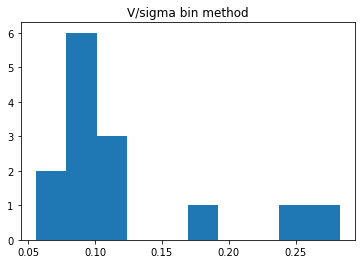

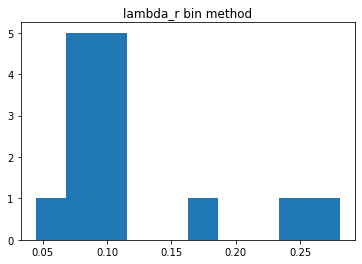

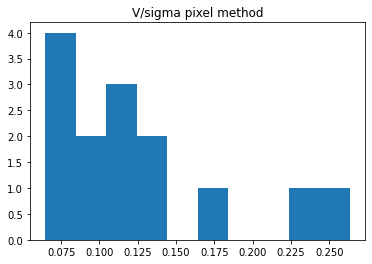

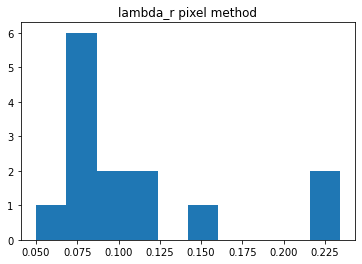

In [11]:
# plug in the extra steps of doing the integral over luminosity weighted pixels instead of just the bins. Will be more spatially accurate as an aperture of radius reff

V_sigmas_bin_method = np.zeros(len(obj_names))
lambda_Rs_bin_method = np.zeros(len(obj_names))
VD_ap_int_rms_bin_method = np.zeros(len(obj_names))
dVD_ap_int_rms_bin_method = np.zeros(len(obj_names))

V_sigmas_pixel_method = np.zeros(len(obj_names))
lambda_Rs_pixel_method = np.zeros(len(obj_names))
VD_ap_int_rms_pixel_method = np.zeros(len(obj_names))
V_ap_int_rms_pixel_method = np.zeros(len(obj_names))
dVD_ap_int_rms_pixel_method = np.zeros(len(obj_names))

b=0

for obj_name in obj_names:
       
    #################
    # set up directories
    obj_abbr = obj_name[4:9] # e.g. J0029
    # data directory
    data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
    # object directory
    dir = f'{data_dir}mosaics/{obj_name}/'
    #KCWI mosaic datacube
    name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
    save_dir = f'{dir}{obj_name}_systematics/'

    #################
    # get velocity and bin data 
    VD=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_VD_binned.txt',
             delimiter=',')
    VD_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_VD.txt',
                     delimiter=',')
    dVD = np.sqrt(np.diagonal(VD_cov))
    V=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_V_binned.txt',
                     delimiter=',')
    # subtract the mean V
    V = V - np.mean(V)
    # import voronoi binning data (#bins, 5215), spectrum for each bin
    voronoi_binning_data = fits.getdata(dir +'voronoi_binning_' + name + '_data.fits')
    num_bins = len(voronoi_binning_data)
    # import pixel data for bins
    vorbin_pixels = np.genfromtxt(f'{dir}voronoi_2d_binning_{name}_output.txt',
                 delimiter='')
    
    #################
    # sum each bin across all wavelengths to get bin luminosities
    bin_luminosities = np.zeros(len(V))
    for i in range(len(V)):
        lum = np.sum(voronoi_binning_data[i])
        bin_luminosities[i] = lum
        

    #################
    # get mean R for each bin by pixel positions
    short_name = obj_name[4:]
    R = calc_R (vorbin_pixels, len(V))
    print(f'length before cutting... {len(R)}')
    effective_radius = reffs[b]
    condition = R < effective_radius
    R_in_aperture = R[condition]
    V_in_aperture = V[condition]
    VD_in_aperture = VD[condition]
    dVD_in_aperture = dVD[condition]
    bin_luminosities_in_aperture = bin_luminosities[condition]
    print(f'length after cutting... {len(R_in_aperture)}')
    #print()

    #################
    # calculate V_sigma
    V_sigmas_bin_method[b], VD_ap_int_rms_bin_method[b], dVD_ap_int_rms_bin_method[b] = lum_weight_V_sigma ( V_in_aperture, VD_in_aperture, dVD_in_aperture, bin_luminosities_in_aperture )
    # calculate lambda_R
    lambda_Rs_bin_method[b] = calc_lambda_R (V_in_aperture, VD_in_aperture, R_in_aperture, bin_luminosities_in_aperture)
    
    ###########################################
    # Now second method
    ###########################################
    
    # bring in cropped datacube and sum across wavelengths
    file = f'{dir}KCWI_{obj_abbr}_icubes_mosaic_0.1457_crop.fits'
    datacube = fits.open(file)[0].data
    summed_datacube = np.nansum(datacube, axis=0)
    normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)
    
    # get effective radius
    if obj_name == 'SDSSJ1306+0600':
        reff = 2.30
    else:    
        # get reff from slacs table
        slacs_table = np.genfromtxt(f'{data_dir}slacs_tableA1.txt', delimiter='', dtype='U10')
        slacs_table_name = obj_name[4:]
        slacs_reffs = slacs_table[:,7].astype(float)
        reff = slacs_reffs[slacs_table[:,0]==slacs_table_name]
        
    # calculate pixel luminosities
    pixel_luminosities = np.zeros(len(vorbin_pixels))
    for i in range(len(vorbin_pixels)):
        x = int(vorbin_pixels[i,0])
        y = int(vorbin_pixels[i,1])
        pixel_luminosity = summed_datacube[y,x]
        pixel_luminosities[i] = pixel_luminosity

    # calculate luminosity weights for each bin contribution to the integrated velocities within the effective radius
    shells=[1.]
    luminosity_weights = calc_luminosity_weights_in_shells(vorbin_pixels, num_bins, bin_luminosities, pixel_luminosities, shells, reff)
    
    # calculate the luminosity-weighted mean V and VD for the aperture within the effective radius
    sum_lum_weights = np.sum(luminosity_weights, axis=0) # sum over the weights for the normalization
    normalized_lum_weights = luminosity_weights / sum_lum_weights
    
    # calculate V_sigma# calculate lambda_R
    V_sigmas_pixel_method[b], lambda_Rs_pixel_method[b], \
        V_ap_int_rms_pixel_method[b], VD_ap_int_rms_pixel_method[b], \
        dVD_ap_int_rms_pixel_method[b]  = calc_aperture_velocities_from_lum_weight_pixels(vorbin_pixels, V, VD, dVD, pixel_luminosities, reff)
    
    b=b+1
    
    
plt.figure()    
plt.title('V/sigma bin method')
plt.hist(V_sigmas_bin_method)
plt.figure()
plt.title('lambda_r bin method')
plt.hist(lambda_Rs_bin_method)
    
plt.figure()    
plt.title('V/sigma pixel method')
plt.hist(V_sigmas_pixel_method)
plt.figure()
plt.title('lambda_r pixel method')
plt.hist(lambda_Rs_pixel_method)


In [12]:
# bring in my classifications table
date = '012323'
#class_df.to_csv(f'{data_dir}classification_table_{date}.csv',index=False)
classifications = pd.read_csv(f'{data_dir}classification_table_{date}.csv')

classes=classifications['class']

# add V_sigma and lambda_R, and ellipticities
classifications['SLACS ellipticity'] = ellipticities
classifications['effective_radius'] = reffs
classifications['SLACS PA'] = slacs_PA_phots
classifications['V_sigma'] = V_sigmas_pixel_method
classifications['lambda_R'] = lambda_Rs_pixel_method

In [13]:
classifications

,obj_name,class,subclass,comments,ellipticity,SLACS ellipticity,effective_radius,SLACS PA,V_sigma,lambda_R,...,dVD_aperture,Vrms_aperture,SLACS VD,SLACS dVD,PA_kin_bspline,dPA_kin_bspline,PA_phot_bspline,delta_PA_bspline,ellipticity_bspline,kcwi_sigmapsf_bspline
0,SDSSJ0029-0055,slow/nonregular,"complex velocity, twist",V 60-80 km/s,0.13,0.160,2.16,26.6,0.107911,0.084878,...,13.468968,137.399536,229.0,18.0,93.0,27.75,210.445044,62.554956,0.167230,0.323041
1,SDSSJ0037-0942,fast/regular,misaligned 31 deg,V 100 km/s,0.30,0.270,2.19,11.4,0.176446,0.158571,...,12.436883,175.155424,279.0,14.0,156.5,8.25,192.045051,35.545051,0.252487,0.329101
2,SDSSJ0330-0020,uncertain,"possible rotation, misaligned 59 deg","Data poor, V 60 km/s",0.17,0.230,1.20,109.6,0.129017,0.109658,...,10.990812,127.515451,212.0,21.0,134.5,89.75,112.123611,22.376389,0.230209,0.431377
3,SDSSJ1112+0826,fast/regular,aligned 0 deg,V 100 km/s,0.24,0.230,1.50,137.5,0.263330,0.234192,...,6.351114,179.667386,320.0,20.0,136.0,18.50,136.454421,0.454421,0.248388,0.244350
4,SDSSJ1204+0358,slow/nonregular,KDC,"V 40 km/s, signif arcs",0.09,0.030,1.47,132.1,0.077882,0.068771,...,7.117512,150.454100,267.0,17.0,112.0,34.50,130.431830,18.431830,0.050000,0.282191
5,SDSSJ1250+0523,fast/regular,"very round, alignment N/A","V 100 km/s, signif arcs",0.04,0.030,1.81,114.8,0.127693,0.112299,...,6.310747,144.751561,252.0,14.0,108.5,21.75,194.750695,86.250695,0.050000,0.243471
6,SDSSJ1306+0600,fast/regular,misaligned 25 deg,"V 60 km/s, No HST image yet",-1.00,0.091,2.30,0.0,0.108517,0.091037,...,13.731453,157.997476,0.0,0.0,-1.0,-1.00,-1.000000,0.000000,-1.000000,-1.000000
7,SDSSJ1402+6321,fast/regular,misaligned 35 deg,V 60 km/s,0.22,0.230,2.70,70.8,0.095982,0.082576,...,9.348608,188.064200,267.0,17.0,90.5,27.75,243.876213,26.623787,0.221003,0.267431
8,SDSSJ1531-0105,slow/nonregular,"no rotation, complex velocity, misaligned 41 deg",V 40 deg,0.31,0.320,2.50,143.5,0.078509,0.069539,...,17.726372,178.899417,279.0,14.0,149.5,89.75,141.600059,7.899941,0.280828,0.304797
9,SDSSJ1538+5817,fast/nonregular,"KDC, CRD? misaligned 22 deg","V 60 km/s outer, 20 deg inner",0.22,0.180,1.58,153.5,0.064735,0.049908,...,8.574878,140.681032,189.0,12.0,130.5,89.75,149.815700,19.315700,0.172418,0.360777


In [132]:
# change subclasses to reflect the correct delta_pa and uncertainty from kinematic pa.
classifications.loc[0, 'subclass'] = 'complex velocity, twist, misaligned 70 deg'
classifications.loc[1, 'subclass'] = 'misaligned 31 deg'
classifications.loc[2, 'subclass'] = 'possible rotation, misaligned 30 deg'
classifications.loc[3, 'subclass'] = 'aligned 0 deg'
classifications.loc[4, 'subclass'] = 'KDC?, misaligned 23 deg'
#classifications.loc[5, 'subclass'] = 'very round, '
#classifications.loc[6, 'subclass'] = ''
classifications.loc[7, 'subclass'] = 'very round, aligned 16 deg'
classifications.loc[8, 'subclass'] = 'no rotation, complex velocity, aligned 3 deg'
classifications.loc[9, 'subclass'] = 'KDC, CRD? core misaligned 22 deg, outer aligned'
classifications.loc[10, 'subclass'] = ' very round, aligned 19 deg'
classifications.loc[11, 'subclass'] = 'very round, complex velocity'
classifications.loc[12, 'subclass'] = 'misaligned 27 deg'
classifications.loc[13, 'subclass'] = 'twist, inner aligned, outer misaligned 22 deg'

In [14]:
# for this purpose, take the ellipticity of J1306 to be the SLACS ellipticity. DO NOT SAVE.
classifications.loc[6, 'ellipticity'] = classifications.loc[6, 'SLACS ellipticity']
classifications.loc[6, 'ellipticity_bspline'] = classifications.loc[6, 'SLACS ellipticity']

In [33]:
slow = classes == 'slow/nonregular'
fast = classes == 'fast/regular'
uncertain = classes == 'uncertain' # J0330
kdc = classes == 'fast/nonregular' #J1538

# separate into fast and slow
eps_slow = ellipticities[slow]
eps_fast = ellipticities[fast]

V_sigmas_slow = V_sigmas_pixel_method[slow]
V_sigmas_fast = V_sigmas_pixel_method[fast]

lambda_Rs_slow = lambda_Rs_pixel_method[slow]
lambda_Rs_fast = lambda_Rs_pixel_method[fast]

# uncertain
eps_uncertain = ellipticities[uncertain]
V_sigmas_uncertain = V_sigmas_pixel_method[uncertain]
lambda_Rs_uncertain = lambda_Rs_pixel_method[uncertain]

# fast nonregular
eps_fast_kdc = ellipticities[kdc]
V_sigmas_fast_kdc = V_sigmas_pixel_method[kdc]
lambda_Rs_fast_kdc = lambda_Rs_pixel_method[kdc]

In [16]:
# make elliptical marker
import matplotlib.path as mpath

# Define the ellipse marker.
circle = mpath.Path.unit_circle()
elliptical_verts = np.copy(circle.vertices)
elliptical_verts[:, 0] *= 1.618
elliptical_marker = mpath.Path(elliptical_verts, circle.codes)

# define negative smaller ellipse
inner_ell_verts = elliptical_verts * 0.8

In [34]:
# make ellipse with line marker
rect = mpath.Path.unit_rectangle()
rect_verts = np.copy(rect.vertices)
rect_verts[:,0] *= 0.1
rect_verts[:,1] *= 2.0
line_marker = mpath.Path(rect_verts, rect.codes)

# make another line marker lower
second_line_verts = rect_verts.copy()
second_line_verts[:,1] += -3.5
second_line_verts[:,1] *= 0.5

rotator = mpath.Path(
    vertices=np.concatenate([elliptical_verts, inner_ell_verts[::-1, ...], rect_verts, second_line_verts]),
    codes=np.concatenate([circle.codes, circle.codes, rect.codes, rect.codes]))

nonregular = 'o'

# make a question mark
uncertain_mark = '$?$'

# fast/non (kdc)
kdc_mark = '^'


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


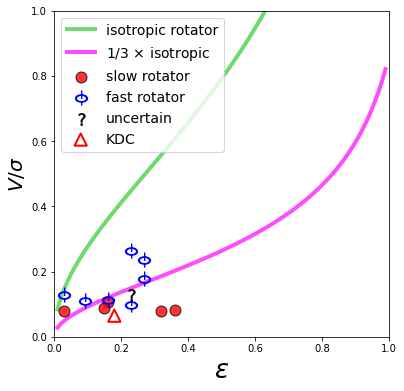

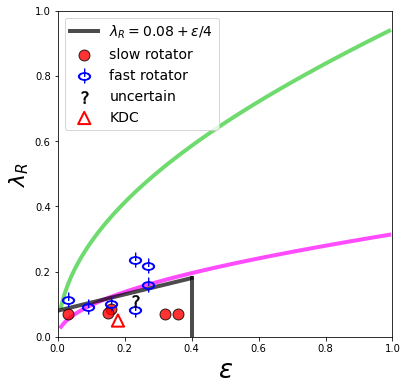

In [18]:
# plot the V_sigma and lambda_R to ellipticities


epsilons = np.linspace(0.0,1.0,100)
V_sigmas_iso = np.zeros(100)
lambda_Rs_iso = np.zeros(100)

i=0
for epsilon in epsilons:
    V_sigma = calc_isotropic_V_sigma(epsilon)
    V_sigmas_iso[i] = V_sigma
    lambda_Rs_iso[i] = calc_Vsig_to_lamR(V_sigma)
    i = i+1

# plot the V_sigma and lambda_R to ellipticities

###################################
# V sigma

plt.figure(figsize=(6,6))
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)

# curves
plt.plot(epsilons, V_sigmas_iso, 
         c='limegreen',linewidth=4,zorder=-1, alpha=0.7,
        label='isotropic rotator')
plt.plot(epsilons, 1/3 * V_sigmas_iso, 
         c='magenta',linewidth=4,zorder=-1, alpha=0.7,
        label=r'1/3 $\times$ isotropic')

# scatter plot for the datapoints
plt.scatter(eps_slow, V_sigmas_slow, 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
plt.scatter(eps_fast, V_sigmas_fast, 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
plt.scatter(eps_uncertain, V_sigmas_uncertain, 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
plt.scatter(eps_fast_kdc, V_sigmas_fast_kdc, 
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')

plt.xlabel(r'$\epsilon$',fontsize=26)
plt.ylabel(r'$V/\sigma$',fontsize=20)
plt.legend(fontsize=14)
plt.savefig(f'{data_dir}mosaics/kinematic_class_vsigma.png')
plt.savefig(f'{data_dir}mosaics/kinematic_class_vsigma.pdf')

###################################
# Lambda_R

plt.figure(figsize=(6,6))
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)

# curves
plt.plot(classifications['sla', lambda_Rs_iso, 
         c='limegreen',linewidth=4,zorder=-1, alpha=0.7)
plt.plot(epsilons, 1/3 * lambda_Rs_iso, 
         c='magenta',linewidth=4,zorder=-1, alpha=0.7)
plt.plot([0.0, 0.4],[0.08, 0.08+0.4/4],
         linestyle='-',c='k',linewidth=4,zorder=-1, alpha=0.7)
plt.plot([0.4, 0.4],[0.0, 0.08+0.4/4],
         linestyle='-',c='k',linewidth=4,zorder=-1, alpha=0.7,
        label=r'$\lambda_R = 0.08 + \epsilon/4$')

# scatter plots for the datapoints
plt.scatter(eps_slow, lambda_Rs_slow, 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
plt.scatter(eps_fast, lambda_Rs_fast, 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
plt.scatter(eps_uncertain, lambda_Rs_uncertain, 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
plt.scatter(eps_fast_kdc, lambda_Rs_fast_kdc, 
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')

plt.xlabel(r'$\epsilon$',fontsize=26)
plt.ylabel(r'$\lambda_R$',fontsize=22)
plt.legend(fontsize=14, loc='upper left')
plt.savefig(f'{data_dir}mosaics/kinematic_class_lambdar.png')
plt.savefig(f'{data_dir}mosaics/kinematic_class_lambdar.pdf')

# Let's add the SLACS and bspline ellipticities

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


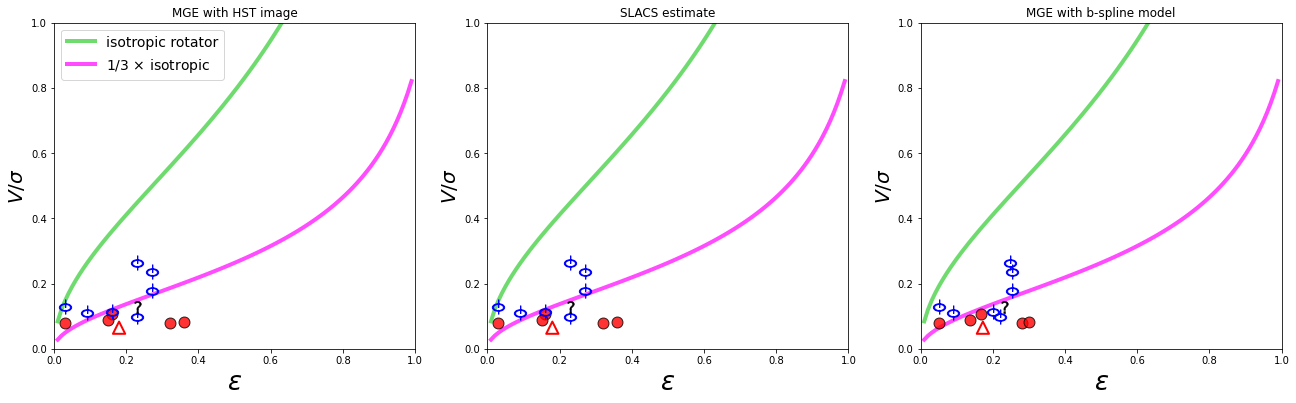

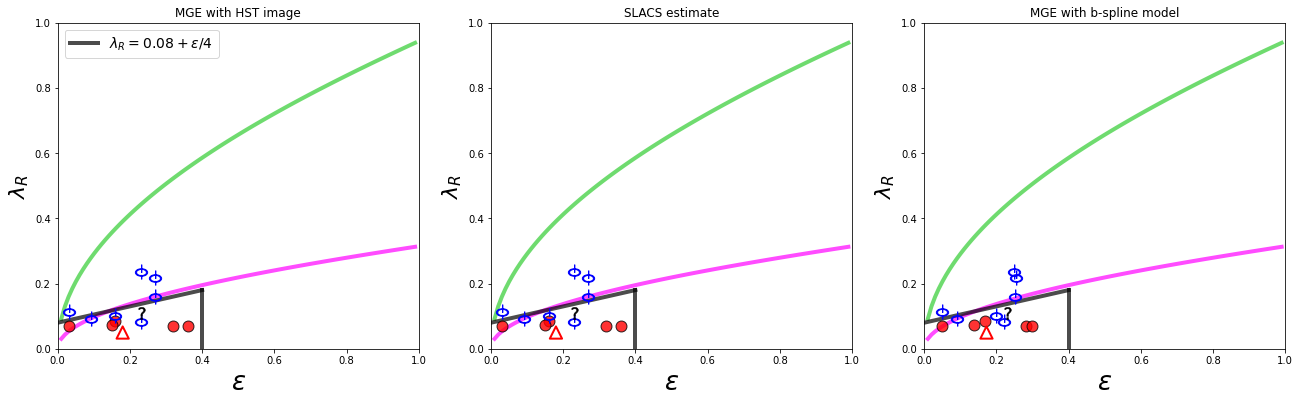

In [42]:
# plot the V_sigma and lambda_R to ellipticities


epsilons = np.linspace(0.0,1.0,100)
V_sigmas_iso = np.zeros(100)
lambda_Rs_iso = np.zeros(100)

i=0
for epsilon in epsilons:
    V_sigma = calc_isotropic_V_sigma(epsilon)
    V_sigmas_iso[i] = V_sigma
    lambda_Rs_iso[i] = calc_Vsig_to_lamR(V_sigma)
    i = i+1

# plot the V_sigma and lambda_R to ellipticities
###################################
# V sigma

fig, axs = plt.subplots(1, 3, figsize=(22,6))

for i in range(3):
    axs[i].set_xlim(0.0,1.0)
    axs[i].set_ylim(0.0,1.0)
    # curves
    axs[i].plot(epsilons, V_sigmas_iso, 
             c='limegreen',linewidth=4,zorder=-1, alpha=0.7,
            label='isotropic rotator')
    axs[i].plot(epsilons, 1/3 * V_sigmas_iso, 
             c='magenta',linewidth=4,zorder=-1, alpha=0.7,
            label=r'1/3 $\times$ isotropic')
    axs[i].set_xlabel(r'$\epsilon$',fontsize=26)
    axs[i].set_ylabel(r'$V/\sigma$',fontsize=20)
axs[0].legend(fontsize=14)

# initial models
axs[0].scatter(eps_slow, V_sigmas_slow, 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
axs[0].scatter(eps_fast, V_sigmas_fast, 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
axs[0].scatter(eps_uncertain, V_sigmas_uncertain, 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
axs[0].scatter(eps_fast_kdc, V_sigmas_fast_kdc, 
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')

# slacs estimates
axs[1].scatter(classifications.loc[slow, 'SLACS ellipticity'], V_sigmas_slow, 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
axs[1].scatter(classifications.loc[fast, 'SLACS ellipticity'], V_sigmas_fast, 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
axs[1].scatter(classifications.loc[uncertain, 'SLACS ellipticity'], V_sigmas_uncertain, 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
axs[1].scatter(classifications.loc[kdc, 'SLACS ellipticity'], V_sigmas_fast_kdc, 
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')

# bspline model
axs[2].scatter(classifications.loc[slow, 'ellipticity_bspline'], V_sigmas_slow, 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
axs[2].scatter(classifications.loc[fast, 'ellipticity_bspline'], V_sigmas_fast, 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
axs[2].scatter(classifications.loc[uncertain, 'ellipticity_bspline'], V_sigmas_uncertain, 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
axs[2].scatter(classifications.loc[kdc, 'ellipticity_bspline'], V_sigmas_fast_kdc, 
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')

# titles
axs[0].set_title('MGE with HST image')
axs[1].set_title('SLACS estimate')
axs[2].set_title('MGE with b-spline model')


plt.savefig(f'{data_dir}mosaics/kinematic_class_vsigma_with_slacs_bspline.png')
plt.savefig(f'{data_dir}mosaics/kinematic_class_vsigma_with_slacs_bspline.pdf')

###################################
# Lambda_R

fig, axs = plt.subplots(1, 3, figsize=(22,6))

for i in range(3):
    axs[i].set_xlim(0.0,1.0)
    axs[i].set_ylim(0.0,1.0)
    # curves
    axs[i].plot(epsilons, lambda_Rs_iso, 
             c='limegreen',linewidth=4,zorder=-1, alpha=0.7)
    axs[i].plot(epsilons, 1/3 * lambda_Rs_iso, 
             c='magenta',linewidth=4,zorder=-1, alpha=0.7)
    axs[i].plot([0.0, 0.4],[0.08, 0.08+0.4/4],
             linestyle='-',c='k',linewidth=4,zorder=-1, alpha=0.7)
    axs[i].plot([0.4, 0.4],[0.0, 0.08+0.4/4],
             linestyle='-',c='k',linewidth=4,zorder=-1, alpha=0.7,
        label=r'$\lambda_R = 0.08 + \epsilon/4$')
    axs[i].set_xlabel(r'$\epsilon$',fontsize=26)
    axs[i].set_ylabel(r'$\lambda_R$',fontsize=22)
axs[0].legend(fontsize=14)

# initial models
axs[0].scatter(eps_slow, lambda_Rs_slow, 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
axs[0].scatter(eps_fast, lambda_Rs_fast, 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
axs[0].scatter(eps_uncertain, lambda_Rs_uncertain, 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
axs[0].scatter(eps_fast_kdc, lambda_Rs_fast_kdc, 
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')

# slacs estimates
axs[1].scatter(classifications.loc[slow, 'SLACS ellipticity'], lambda_Rs_slow, 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
axs[1].scatter(classifications.loc[fast, 'SLACS ellipticity'], lambda_Rs_fast, 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
axs[1].scatter(classifications.loc[uncertain, 'SLACS ellipticity'], lambda_Rs_uncertain, 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
axs[1].scatter(classifications.loc[kdc, 'SLACS ellipticity'], lambda_Rs_fast_kdc,
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')

# bspline model
axs[2].scatter(classifications.loc[slow, 'ellipticity_bspline'], lambda_Rs_slow, 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
axs[2].scatter(classifications.loc[fast, 'ellipticity_bspline'], lambda_Rs_fast, 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
axs[2].scatter(classifications.loc[uncertain, 'ellipticity_bspline'], lambda_Rs_uncertain,
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
axs[2].scatter(classifications.loc[kdc, 'ellipticity_bspline'], lambda_Rs_fast_kdc,
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')

# titles
axs[0].set_title('MGE with HST image')
axs[1].set_title('SLACS estimate')
axs[2].set_title('MGE with b-spline model')

plt.savefig(f'{data_dir}mosaics/kinematic_class_lambdar_with_slacs_bspline.png')
plt.savefig(f'{data_dir}mosaics/kinematic_class_lambdar_with_slacs_bspline.pdf')

# Whats the deal with these fast rotators being in the slow regime???

In [126]:
slow_fast = (V_sigmas_pixel_method < 0.12) & (classes != 'slow/nonregular')
classifications[slow_fast]

,obj_name,class,subclass,comments,ellipticity,SLACS ellipticity,effective_radius,V_sigma,lambda_R
6,SDSSJ1306+0600,fast/regular,misaligned 25 deg,"V 60 km/s, No HST image yet",0.091,0.091,2.30,0.108517,0.091037
7,SDSSJ1402+6321,fast/regular,"very round, aligned 16 deg",V 60 km/s,0.220,0.230,2.70,0.095982,0.082576
9,SDSSJ1538+5817,fast/nonregular,"KDC, CRD? core misaligned 22 deg, outer aligned","V 60 km/s outer, 20 deg inner",0.220,0.180,1.58,0.064735,0.049908
12,SDSSJ1630+4520,fast/regular,misaligned 27 deg,V 60 deg,0.160,0.160,1.96,0.113668,0.100951


In [127]:
fast_fast = (V_sigmas_pixel_method > 0.12)
classifications[fast_fast]

,obj_name,class,subclass,comments,ellipticity,SLACS ellipticity,effective_radius,V_sigma,lambda_R
1,SDSSJ0037-0942,fast/regular,misaligned 31 deg,V 100 km/s,0.30,0.27,2.19,0.176446,0.158571
2,SDSSJ0330-0020,uncertain,"possible rotation, misaligned 30 deg","Data poor, V 60 km/s",0.17,0.23,1.20,0.129017,0.109658
3,SDSSJ1112+0826,fast/regular,aligned 0 deg,V 100 km/s,0.24,0.23,1.50,0.263330,0.234192
5,SDSSJ1250+0523,fast/regular,"very round, alignment N/A","V 100 km/s, signif arcs",0.04,0.03,1.81,0.127693,0.112299
10,SDSSJ1621+3931,fast/regular,"very round, aligned 19 deg","V 100 km/s, pretty round",0.35,0.27,2.14,0.235023,0.216519


# It looks like V = 60 km/s is not a great decider for fast vs slow in this case, should I start doing slow/regular?
# No, we should keep visual classification and Lambda_r classification separate.
# We need to look at stellar mass (M* > 2e11Msun) and velocity dispersion (sigma_e > 160 km/s) like Michele's email response
# But we should also include the classification by V_sigma/lambda_r

In [151]:
# classification according to the Cappellari paper

V_sigmas = classifications['V_sigma']
lambda_Rs = classifications['lambda_R']

V_sig_class = np.empty(14, dtype='U5')
lam_R_class = np.empty(14, dtype='U5')

for i in range(14):
    
    #print(obj_names[i])
    
    V_sig = V_sigmas[i]
    lam_R = lambda_Rs[i]
    ellip = ellipticities[i]
    
    V_sig_bound = calc_isotropic_V_sigma(ellip) / 3
    lam_R_bound = 0.08 + ellip/4
    
    if (V_sig < V_sig_bound):
        V_sig_class[i] = 'slow'
    elif (V_sig > V_sig_bound):
        V_sig_class[i] = 'fast'
    
    if (lam_R < lam_R_bound):
        lam_R_class[i] = 'slow'
    elif (lam_R > lam_R_bound):
        lam_R_class[i] = 'fast'
    
classifications['V_sigma_class'] = V_sig_class
classifications['lambda_R_class'] = lam_R_class

# Also add position angles, assuming the PA_phot is much more robust so uncertainty is dominated by dPA_kins.
# But how do I characterize the uncertainty on the photometric position angle?
# I can look at my measurement against SLACS measurement

In [187]:
PA_phots = np.array([203.42758808, 187.76112391, 104.22337576, 136.0986021 ,
                   135.08008317, 252.03377153,  -1.        , 255.30263871,
                   145.97245114, 153.33974639, 159.31355559, 185.74581685,
                   257.54008489, 208.0766188 ])

delta_PAs = np.abs([ 110.,   31.,  -30.,    0.,   23.,  143.,   -1.,  164.,   -3.,
                    22.,  199.,  125., -153.,  202.])

PA_kins = np.array([ 93. , 156.5, 134.5, 136. , 112. , 108.5,  -1. ,  90.5, 149.5,
                   130.5, -40.5,  60.5, 411. ,   5.5])

dPA_kins = np.array([27.75,  8.25, 89.75, 18.5 , 34.5 , 21.75, -1.  , 27.75, 89.75,
                   89.75, 19.25, 89.75, 34.  , 37.  ])

for i in range(14):
    if PA_phots[i] > 180:
        PA_phots[i] = PA_phots[i] - 180
    if delta_PAs[i] > 90:
        delta_PAs[i] = np.abs(180 - delta_PAs[i])
    if PA_kins[i] > 180:
        PA_kins[i] = PA_kins[i] - 180
    if dPA_kins[i] > 180:
        dPA_kins[i] = dPA_kins[i] - 180

In [189]:
classifications['PA_phot'] = PA_phots
classifications['delta_PA'] = delta_PAs
classifications['PA_kin'] = PA_kins
classifications['dPA_kin'] = dPA_kins

In [190]:
classifications[['SLACS PA', 'PA_phot']]

,SLACS PA,PA_phot
0,26.6,23.427588
1,11.4,7.761124
2,109.6,104.223376
3,137.5,136.098602
4,132.1,135.080083
5,114.8,72.033772
6,2.3,-1.000000
7,70.8,75.302639
8,143.5,145.972451
9,153.5,153.339746


# They are close.

In [193]:
classifications

,obj_name,class,subclass,comments,ellipticity,SLACS ellipticity,effective_radius,SLACS PA,V_sigma,lambda_R,PA_phot,delta_PA,PA_kin,dPA_kin
0,SDSSJ0029-0055,slow/nonregular,"complex velocity, twist",V 60-80 km/s,0.13,0.160,2.16,26.6,0.107911,0.084878,23.427588,70.0,93.0,27.75
1,SDSSJ0037-0942,fast/regular,misaligned 31 deg,V 100 km/s,0.30,0.270,2.19,11.4,0.176446,0.158571,7.761124,31.0,156.5,8.25
2,SDSSJ0330-0020,uncertain,"possible rotation, misaligned 59 deg","Data poor, V 60 km/s",0.17,0.230,1.20,109.6,0.129017,0.109658,104.223376,30.0,134.5,89.75
3,SDSSJ1112+0826,fast/regular,aligned 0 deg,V 100 km/s,0.24,0.230,1.50,137.5,0.263330,0.234192,136.098602,0.0,136.0,18.50
4,SDSSJ1204+0358,slow/nonregular,KDC,"V 40 km/s, signif arcs",0.09,0.030,1.47,132.1,0.077882,0.068771,135.080083,23.0,112.0,34.50
5,SDSSJ1250+0523,fast/regular,"very round, alignment N/A","V 100 km/s, signif arcs",0.04,0.030,1.81,114.8,0.127693,0.112299,72.033772,37.0,108.5,21.75
6,SDSSJ1306+0600,fast/regular,misaligned 25 deg,"V 60 km/s, No HST image yet",-1.00,0.091,2.30,2.3,0.108517,0.091037,-1.000000,1.0,-1.0,-1.00
7,SDSSJ1402+6321,fast/regular,misaligned 35 deg,V 60 km/s,0.22,0.230,2.70,70.8,0.095982,0.082576,75.302639,16.0,90.5,27.75
8,SDSSJ1531-0105,slow/nonregular,"no rotation, complex velocity, misaligned 41 deg",V 40 deg,0.31,0.320,2.50,143.5,0.078509,0.069539,145.972451,3.0,149.5,89.75
9,SDSSJ1538+5817,fast/nonregular,"KDC, CRD? misaligned 22 deg","V 60 km/s outer, 20 deg inner",0.22,0.180,1.58,153.5,0.064735,0.049908,153.339746,22.0,130.5,89.75


In [235]:
# bring in my classifications table
date = '011323'
classifications.to_csv(f'{data_dir}classification_table_{date}.csv',index=False)
#classifications = pd.read_csv(f'{data_dir}classification_table_{date}.csv')

# Save the classifications table with the aperture integrated velocity, sigma, rms velocity, and uncertainty, and the SLACS velocity dispersion and error

In [203]:
V_aperture = V_ap_int_rms_pixel_method
VD_aperture = VD_ap_int_rms_pixel_method
dVD_aperture = dVD_ap_int_rms_pixel_method
Vrms_aperture = np.sqrt((V_aperture**2 + VD_aperture**2)/2)

In [233]:
classifications['V_aperture'] = V_aperture
classifications['VD_aperture'] = VD_aperture
classifications['dVD_aperture'] = dVD_aperture
classifications['Vrms_aperture'] = Vrms_aperture
classifications['SLACS VD'] = sdss_sigmas
classifications['SLACS dVD'] = sdss_sigmas_err

In [234]:
classifications

,obj_name,class,subclass,comments,ellipticity,SLACS ellipticity,effective_radius,SLACS PA,V_sigma,lambda_R,...,PA_kin,dPA_kin,oblate_prolate,SLACS delta_PA,V_aperture,VD_aperture,dVD_aperture,Vrms_aperture,SLACS VD,SLACS dVD
0,SDSSJ0029-0055,slow/nonregular,"complex velocity, twist",V 60-80 km/s,0.13,0.160,2.16,26.6,0.107911,0.084878,...,93.0,27.75,likely prolate,66.4,20.847441,193.190707,13.468968,137.399536,229.0,18.0
1,SDSSJ0037-0942,fast/regular,misaligned 31 deg,V 100 km/s,0.30,0.270,2.19,11.4,0.176446,0.158571,...,156.5,8.25,likely oblate,34.9,43.042056,243.938980,12.436883,175.155424,279.0,14.0
2,SDSSJ0330-0020,uncertain,"possible rotation, misaligned 59 deg","Data poor, V 60 km/s",0.17,0.230,1.20,109.6,0.129017,0.109658,...,134.5,89.75,uncertain,24.9,23.074875,178.851700,10.990812,127.515451,212.0,21.0
3,SDSSJ1112+0826,fast/regular,aligned 0 deg,V 100 km/s,0.24,0.230,1.50,137.5,0.263330,0.234192,...,136.0,18.50,likely oblate,1.5,64.703207,245.711690,6.351114,179.667386,320.0,20.0
4,SDSSJ1204+0358,slow/nonregular,KDC,"V 40 km/s, signif arcs",0.09,0.030,1.47,132.1,0.077882,0.068771,...,112.0,34.50,uncertain,20.1,16.521149,212.131856,7.117512,150.454100,267.0,17.0
5,SDSSJ1250+0523,fast/regular,"very round, alignment N/A","V 100 km/s, signif arcs",0.04,0.030,1.81,114.8,0.127693,0.112299,...,108.5,21.75,likely oblate,6.3,25.929456,203.060809,6.310747,144.751561,252.0,14.0
6,SDSSJ1306+0600,fast/regular,misaligned 25 deg,"V 60 km/s, No HST image yet",-1.00,0.091,2.30,2.3,0.108517,0.091037,...,-1.0,-1.00,NaN,3.3,24.105829,222.138051,13.731453,157.997476,0.0,0.0
7,SDSSJ1402+6321,fast/regular,misaligned 35 deg,V 60 km/s,0.22,0.230,2.70,70.8,0.095982,0.082576,...,90.5,27.75,likely oblate,19.7,25.410890,264.746243,9.348608,188.064200,267.0,17.0
8,SDSSJ1531-0105,slow/nonregular,"no rotation, complex velocity, misaligned 41 deg",V 40 deg,0.31,0.320,2.50,143.5,0.078509,0.069539,...,149.5,89.75,uncertain,6.0,19.802102,252.225850,17.726372,178.899417,279.0,14.0
9,SDSSJ1538+5817,fast/nonregular,"KDC, CRD? misaligned 22 deg","V 60 km/s outer, 20 deg inner",0.22,0.180,1.58,153.5,0.064735,0.049908,...,130.5,89.75,uncertain,23.0,12.852247,198.537466,8.574878,140.681032,189.0,12.0


# Michele said sigma_e > 160 km/s would be a good division

(array([1., 1., 2., 1., 0., 1., 2., 4., 1., 1.]),
 array([178.85169974, 187.4411541 , 196.03060847, 204.62006283,
        213.2095172 , 221.79897156, 230.38842593, 238.97788029,
        247.56733465, 256.15678902, 264.74624338]),
 <BarContainer object of 10 artists>)

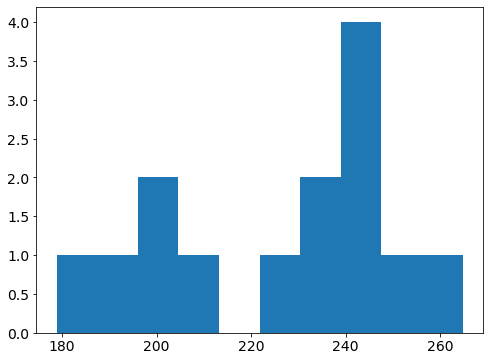

In [207]:
plt.hist(classifications['VD_aperture'])

# Every single one of them is more than 160 km/s

In [215]:
VD_ap_int_rms_bin_method - VD_ap_int_rms_pixel_method

array([6.17628554e+00, 1.52592984e+01, 4.88943371e+01, 9.53804233e+00,
       3.45603558e+01, 2.50127994e+01, 2.52189774e+00, 1.73080044e+00,
       1.92886151e+00, 2.98739809e+01, 3.57443204e+00, 1.35002683e+01,
       1.59111807e+01, 9.31620860e-03])

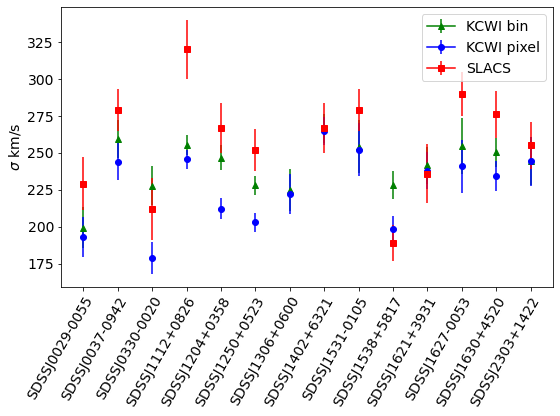

In [288]:
for i in range(14):
    plt.errorbar(i, VD_ap_int_rms_bin_method[i], yerr=dVD_ap_int_rms_bin_method[i], c='g', marker='^')
    plt.errorbar(i, VD_ap_int_rms_pixel_method[i], yerr=dVD_ap_int_rms_pixel_method[i], c='b', marker='o')
    if i==6:
        continue
    plt.errorbar(i, sdss_sigmas[i], yerr=sdss_sigmas_err[i], c='r', marker='s')
    if i==0:
        plt.legend(['KCWI bin', 'KCWI pixel', 'SLACS'])
plt.xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
plt.ylabel(r'$\sigma$ km/s')
plt.tight_layout()
plt.savefig(f'{data_dir}aperture_integrated_velocity_dispersions_{date}.pdf')

# So the bin method estimates higher velocity dispersions, and SLACS is even a little higher.

In [223]:
np.mean((VD_ap_int_rms_bin_method - VD_ap_int_rms_pixel_method)/VD_ap_int_rms_pixel_method)

0.07198562686609024

In [228]:
np.mean(dVD_ap_int_rms_pixel_method/VD_ap_int_rms_pixel_method)

0.051346280618176185

# The mean difference between the estimates is 7%, while the measurement uncertainties are 5%

In [247]:
obj_names

['SDSSJ0029-0055',
 'SDSSJ0037-0942',
 'SDSSJ0330-0020',
 'SDSSJ1112+0826',
 'SDSSJ1204+0358',
 'SDSSJ1250+0523',
 'SDSSJ1306+0600',
 'SDSSJ1402+6321',
 'SDSSJ1531-0105',
 'SDSSJ1538+5817',
 'SDSSJ1621+3931',
 'SDSSJ1627-0053',
 'SDSSJ1630+4520',
 'SDSSJ2303+1422']

# Look at stellar masses from https://arxiv.org/pdf/1407.5633.pdf
## Take Mag_r, M/L_r from tables 1 and 2
## See how they split across M_* = 2e11 M_sun

In [300]:
# take the sdss r mag
r_mags = np.array([-22.79,
                  -23.20,
                  -22.93,
                  -23.02,
                   -22.16,
                   -23.11,
                   0.0,
                   -23.14,
                   -23.04,
                   -21.98,
                   -23.22,
                   -22.78,
                   -23.18,
                   -22.83
                  ])

# solar magnitude in sdss r
mag_sun_r = 4.64 # (Blanton & Roweis 2007)

# convert to luminosity
lum_rs = 10**(0.4*(mag_sun_r - r_mags)) # solar luminosities

# take the ml_MFL, logs
log_ml_rs = np.array([0.693,
                     0.665,
                     0.487,
                     0.793,
                     0.835,
                     0.548, 
                      -1.0,
                      0.706, 
                     0.728,
                     0.577,
                     0.571,
                     0.830,
                     0.671,
                     0.779])

# convert from log
ml_rs = 10**log_ml_rs

# multiply mass to light by the light to get mass
stellar_masses = ml_rs * lum_rs

stellar_masses

array([4.62381021e+11, 6.32411851e+11, 3.27340695e+11, 7.19448978e+11,
       3.58921935e+11, 4.44631267e+11, 7.17794291e+00, 6.57657837e+11,
       6.30957344e+11, 1.67880402e+11, 5.18800039e+11, 6.28058359e+11,
       6.29506183e+11, 5.84790084e+11])

In [295]:
# from https://ui.adsabs.harvard.edu/abs/2009ApJ...705.1099A/abstract
# stellar masses are in log
log_stellar_masses_salp = np.array([11.58,
                                   11.73,
                                   11.58,
                                   11.76,
                                   11.45,
                                   11.77,
                                   11.43,
                                   11.79,
                                   11.68,
                                   11.28,
                                   11.70,
                                   11.70,
                                   11.86,
                                   11.71]) 

# take from log
stellar_masses_salp = 10**log_stellar_masses_salp

# convert to scientific notation
for i in range(len(stellar_masses_salp)):
    sci = np.format_float_scientific(stellar_masses_salp[i])
    stellar_masses_salp[i] = sci

stellar_masses_salp

array([3.80189396e+11, 5.37031796e+11, 3.80189396e+11, 5.75439937e+11,
       2.81838293e+11, 5.88843655e+11, 2.69153480e+11, 6.16595002e+11,
       4.78630092e+11, 1.90546072e+11, 5.01187234e+11, 5.01187234e+11,
       7.24435960e+11, 5.12861384e+11])

In [324]:
# add the stellar masses
classifications['stellar_mass'] = stellar_masses
# for i=6 use salp
classifications.loc[6, 'stellar_mass'] = stellar_masses_salp[6]

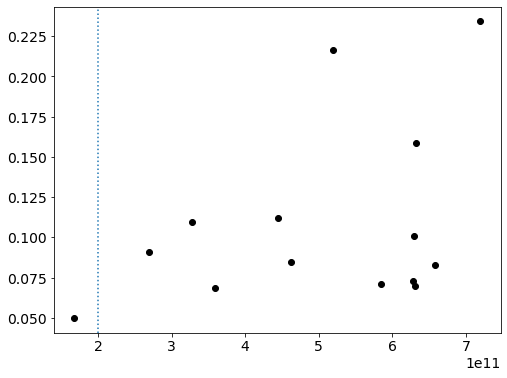

In [326]:
# plot against lambda_R
colors=['k','b','g','r']
plt.scatter(classifications['stellar_mass'], lambda_Rs, color='k')
plt.axvline(2e11, linestyle=':')

# Plot the lambda_R against basically everything else

In [310]:
classifications.columns

Index(['obj_name', 'class', 'subclass', 'comments', 'ellipticity',
       'SLACS ellipticity', 'effective_radius', 'SLACS PA', 'V_sigma',
       'lambda_R', 'PA_phot', 'delta_PA', 'PA_kin', 'dPA_kin',
       'oblate_prolate', 'SLACS delta_PA', 'V_aperture', 'VD_aperture',
       'dVD_aperture', 'Vrms_aperture', 'SLACS VD', 'SLACS dVD',
       'stellar_mass'],
      dtype='object')

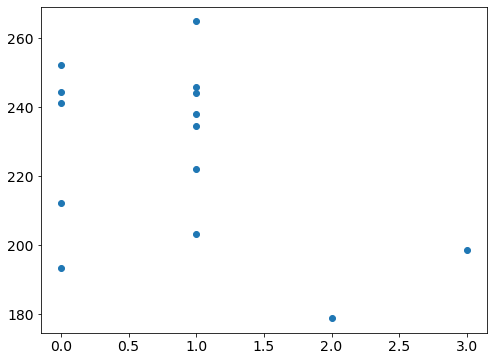

In [311]:
classes_num = np.empty(14, dtype='int64')
labels_again = np.empty(14, dtype='U15')
for i in range(14):
    if classifications.loc[i, 'class'] == 'slow/nonregular':
        classes_num[i] = 0
        labels_again[i] = 'slow/nonregular'
    elif classifications.loc[i, 'class'] == 'fast/regular':
        classes_num[i] = 1
        labels_again[i] = 'fast/regular'
    elif classifications.loc[i, 'class'] == 'uncertain':
        classes_num[i] = 2
        labels_again[i] = 'uncertain'
    else:
        classes_num[i] = 3
        labels_again[i] = 'KDC'
plt.scatter(classes_num, VD_aperture)

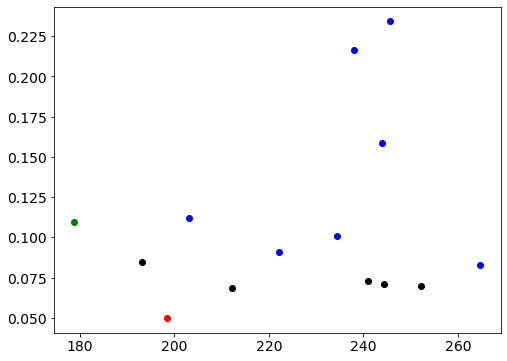

In [312]:
colors=['k','b','g','r']
for i in range(14):
    class_num = classes_num[i]
    plt.scatter(VD_aperture[i], lambda_Rs[i], color=colors[class_num])
#plt.legend()

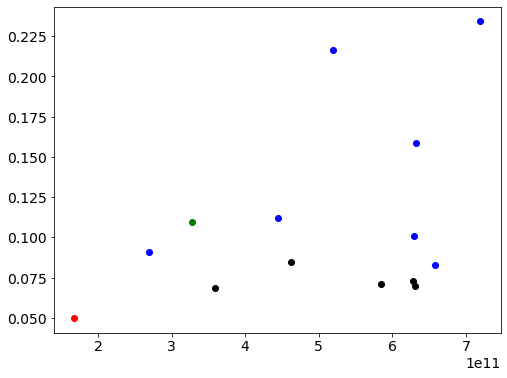

In [331]:
colors=['k','b','g','r']
for i in range(14):
    class_num = classes_num[i]
    plt.scatter(classifications.loc[i, 'stellar_mass'], lambda_Rs[i], color=colors[class_num])
#plt.legend()

In [332]:
slow_rotators = classifications[classes_num == 0]
regular_rotators = classifications[classes_num == 1]
uncertain_object = classifications[classes_num == 2]
kdc_object = classifications[classes_num == 3]


In [346]:
date = '011723'

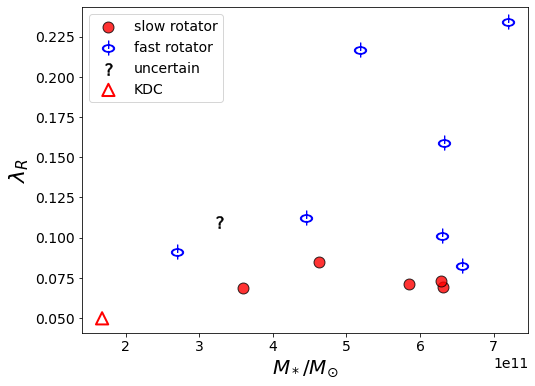

In [347]:
# scatter plot for the datapoints
plt.scatter(slow_rotators['stellar_mass'], slow_rotators['lambda_R'], 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
plt.scatter(regular_rotators['stellar_mass'], regular_rotators['lambda_R'], 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
plt.scatter(uncertain_object['stellar_mass'], uncertain_object['lambda_R'], 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
plt.scatter(kdc_object['stellar_mass'], kdc_object['lambda_R'], 
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')
plt.xlabel(r'$M_*/M_{\odot}$', fontsize=20)
plt.ylabel(r'$\lambda_R$', fontsize=22)
plt.legend(fontsize=14, loc='upper left')
plt.savefig(f'{data_dir}lambdar_mstar_{date}.pdf')

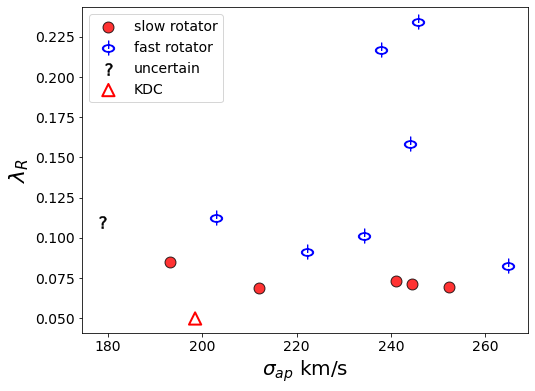

In [348]:
# scatter plot for the datapoints
plt.scatter(slow_rotators['VD_aperture'], slow_rotators['lambda_R'], 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotator', alpha=0.8)
plt.scatter(regular_rotators['VD_aperture'], regular_rotators['lambda_R'], 
            s=230, c='b', marker=rotator, 
            label='fast rotator')
plt.scatter(uncertain_object['VD_aperture'], uncertain_object['lambda_R'], 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
plt.scatter(kdc_object['VD_aperture'], kdc_object['lambda_R'], 
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')
plt.xlabel(r'$\sigma_{ap}$ km/s', fontsize=20)
plt.ylabel(r'$\lambda_R$', fontsize=22)
plt.legend(fontsize=14, loc='upper left')
plt.savefig(f'{data_dir}lambdar_sigma_{date}.pdf')

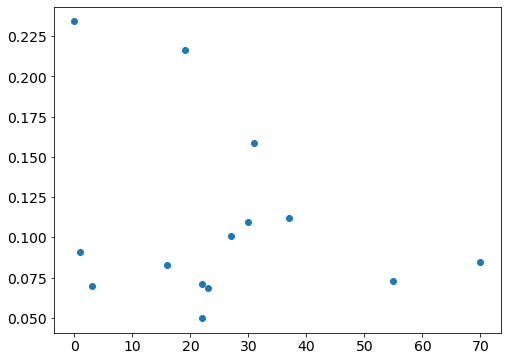

In [277]:
plt.scatter(classifications['delta_PA'], lambda_Rs)

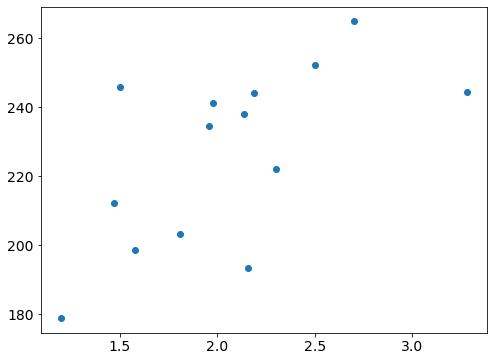

In [282]:
plt.scatter(classifications['effective_radius'], VD_aperture)

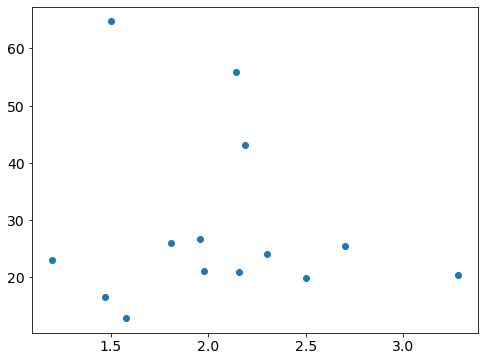

In [283]:
plt.scatter(classifications['effective_radius'], V_aperture)

(0.0, 0.5)

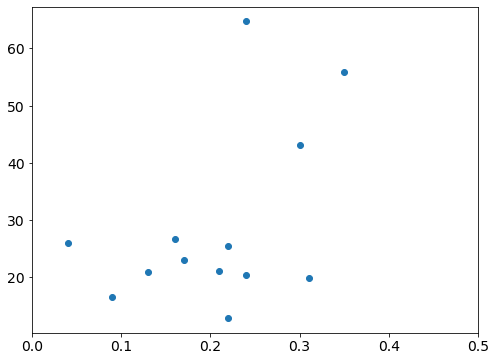

In [287]:
plt.scatter(classifications['ellipticity'], V_aperture)
plt.xlim(0, 0.5)

In [ ]:
|